In [2]:
import numpy as np
import pandas as pd
from math import sin, cos, sqrt, atan2, radians
import datetime
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix,ConfusionMatrixDisplay,precision_score,recall_score,roc_curve,roc_auc_score,auc


### Dataset source: https://www.kaggle.com/datasets/kartik2112/fraud-detection

In [3]:
#Load file
file=pd.read_csv('fraudTrain.csv')
file_test=pd.read_csv('fraudTest.csv')

In [4]:
# delete unnamed column
df = file.loc[:, ~file.columns.str.contains('^Unnamed')]

In [5]:
df.head(5)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [6]:
#convert latitude and longitude radians for measuring distance
df['radian_lat'] = df.apply(lambda row: radians(row.lat), axis = 1)


In [7]:
#convert latitude and longitude radians for measuring distance

df['radian_long'] = df.apply(lambda row: radians(row.long), axis = 1)
df['radian_mlat'] = df.apply(lambda row: radians(row.merch_lat), axis = 1)
df['radian_mlong'] = df.apply(lambda row: radians(row.merch_long), axis = 1)


In [8]:
df.head(5)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,radian_lat,radian_long,radian_mlat,radian_mlong
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,0.629694,-1.416825,0.628516,-1.432013
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,0.853253,-2.063162,0.857987,-2.062743
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,0.736194,-1.959342,0.753122,-1.957465
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,0.806876,-1.956755,0.820904,-1.964561
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,0.670568,-1.386889,0.675006,-1.372395


In [9]:
# Function to Get distance between two points 

# approximate radius of earth in km
def dist(lat1,lon1,lat2,lon2):
    R=6373.0
    dlon=lon2-lon1
    dlat=lat2-lat1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))

    return R * c

In [10]:
# Add new column with distance between owner and merchant
df['ownerToMerdist']= dist(df['radian_lat'],df['radian_long'],df['radian_mlat'],df['radian_mlong'])


In [11]:
df.head(5)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,trans_num,unix_time,merch_lat,merch_long,is_fraud,radian_lat,radian_long,radian_mlat,radian_mlong,ownerToMerdist
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,0.629694,-1.416825,0.628516,-1.432013,78.622242
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,0.853253,-2.063162,0.857987,-2.062743,30.221660
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,0.736194,-1.959342,0.753122,-1.957465,108.240051
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,0.806876,-1.956755,0.820904,-1.964561,95.703265
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,0.670568,-1.386889,0.675006,-1.372395,77.581090


In [12]:
#add date_time column by converting trans_date_trans_time to date time 
df['date_time']=pd.to_datetime(df['trans_date_trans_time'])

In [13]:
# strip out date and time and add as new column
df['date']=df['date_time'].dt.date
df['time']=df['date_time'].dt.time

In [14]:
# strip out hour and add as new column

df['time_hour']=df['date_time'].dt.hour

In [15]:
df.tail(5)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,is_fraud,radian_lat,radian_long,radian_mlat,radian_mlong,ownerToMerdist,date_time,date,time,time_hour
1296670,2020-06-21 12:12:08,30263540414123,fraud_Reichel Inc,entertainment,15.56,Erik,Patterson,M,162 Jessica Row Apt. 072,Hatch,...,0,0.658295,-1.963106,0.643001,-1.949372,119.789729,2020-06-21 12:12:08,2020-06-21,12:12:08,12
1296671,2020-06-21 12:12:19,6011149206456997,fraud_Abernathy and Sons,food_dining,51.70,Jeffrey,White,M,8617 Holmes Terrace Suite 651,Tuscarora,...,0,0.685333,-1.352806,0.679053,-1.365660,75.127662,2020-06-21 12:12:19,2020-06-21,12:12:19,12
1296672,2020-06-21 12:12:32,3514865930894695,fraud_Stiedemann Ltd,food_dining,105.93,Christopher,Castaneda,M,1632 Cohen Drive Suite 639,High Rolls Mountain Park,...,0,0.574904,-1.846888,0.586771,-1.834874,99.078827,2020-06-21 12:12:32,2020-06-21,12:12:32,12
1296673,2020-06-21 12:13:36,2720012583106919,"fraud_Reinger, Weissnat and Strosin",food_dining,74.90,Joseph,Murray,M,42933 Ryan Underpass,Manderson,...,0,0.756646,-1.789680,0.746808,-1.801898,84.654219,2020-06-21 12:13:36,2020-06-21,12:13:36,12
1296674,2020-06-21 12:13:37,4292902571056973207,"fraud_Langosh, Wintheiser and Hyatt",food_dining,4.30,Jeffrey,Smith,M,135 Joseph Mountains,Sula,...,0,0.800117,-1.987490,0.812730,-1.992924,83.879979,2020-06-21 12:13:37,2020-06-21,12:13:37,12


In [16]:
df.head(1).T

,0
trans_date_trans_time,2019-01-01 00:00:18
cc_num,2703186189652095
merchant,"fraud_Rippin, Kub and Mann"
category,misc_net
amt,4.97
first,Jennifer
last,Banks
gender,F
street,561 Perry Cove
city,Moravian Falls


In [17]:
# set today to last date of dateset (Dec 31 2020
today = datetime.datetime(2020, 12, 31)

In [18]:
today

datetime.datetime(2020, 12, 31, 0, 0)

In [19]:
# convert date of birth to date_time format
df['dob'] =pd.to_datetime(df['dob'], format='%Y/%m/%d')

In [20]:
# set now to last date of dateset (Dec 31 2020)

now = pd.Timestamp('12-31-2020')

In [21]:
# calculate age as of last date of dataset i.e "today"
df['dob'] = df['dob'].where(df['dob'] < now, df['dob'] -  np.timedelta64(100, 'Y'))   
df['age'] = (now - df['dob']).astype('<m8[Y]')    

In [22]:
df.head(2)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,radian_lat,radian_long,radian_mlat,radian_mlong,ownerToMerdist,date_time,date,time,time_hour,age
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,0.629694,-1.416825,0.628516,-1.432013,78.622242,2019-01-01 00:00:18,2019-01-01,00:00:18,0,32.0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,0.853253,-2.063162,0.857987,-2.062743,30.221660,2019-01-01 00:00:44,2019-01-01,00:00:44,0,42.0


In [23]:
fraud_df=df[df['is_fraud']==1]

<AxesSubplot:xlabel='age', ylabel='Count'>

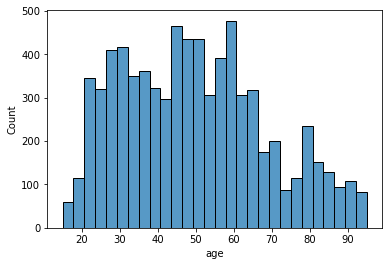

In [24]:
sns.histplot(data=fraud_df, x="age")


<AxesSubplot:xlabel='time_hour', ylabel='Count'>

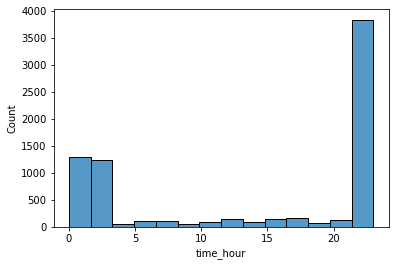

In [25]:
sns.histplot(data=fraud_df, x="time_hour")


In [26]:
fraud_df.groupby('time_hour').size()


time_hour
0      635
1      658
2      625
3      609
4       46
5       60
6       40
7       56
8       49
9       47
10      40
11      42
12      67
13      80
14      86
15      79
16      76
17      78
18      81
19      81
20      62
21      74
22    1931
23    1904
dtype: int64

<AxesSubplot:xlabel='ownerToMerdist', ylabel='Count'>

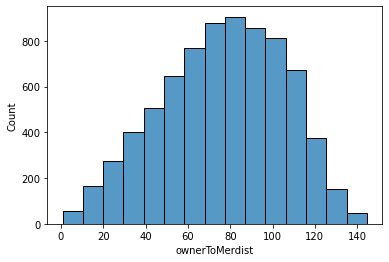

In [27]:
sns.histplot(data=fraud_df, x="ownerToMerdist", bins=15)


In [28]:
df.dtypes

trans_date_trans_time            object
cc_num                            int64
merchant                         object
category                         object
amt                             float64
first                            object
last                             object
gender                           object
street                           object
city                             object
state                            object
zip                               int64
lat                             float64
long                            float64
city_pop                          int64
job                              object
dob                      datetime64[ns]
trans_num                        object
unix_time                         int64
merch_lat                       float64
merch_long                      float64
is_fraud                          int64
radian_lat                      float64
radian_long                     float64
radian_mlat                     float64


In [29]:
# convert gender and is_fraud to category
df['is_fraud']=df['is_fraud'].astype("category")
df['gender']=df['gender'].astype("category")

In [30]:
#Table with fraud victim breakdown by Gender
df_plot_gender = df.groupby(['gender', 'is_fraud']).size()
df_plot_gender = df_plot_gender.reset_index()
df_plot_gender = df_plot_gender.rename({0:'count'}, axis=1)

df_plot_gender

,gender,is_fraud,count
0,F,0,706128
1,F,1,3735
2,M,0,583041
3,M,1,3771


In [31]:
#add percentage given that different sample size
male_female=df.groupby(['gender']).size().reset_index().rename({0:'total_gender'}, axis=1)
df_plot_gender=df_plot_gender.merge(male_female,on='gender')
df_plot_gender['percentage']=(df_plot_gender['count']/df_plot_gender['total_gender'])*(100)
df_plot_gender['percentage']=df_plot_gender['percentage'].round(2)

In [32]:
df_plot_gender

,gender,is_fraud,count,total_gender,percentage
0,F,0,706128,709863,99.47
1,F,1,3735,709863,0.53
2,M,0,583041,586812,99.36
3,M,1,3771,586812,0.64


Text(0.5, 0.98, 'Amount of fraud and non-fraud transactions by Gender')

<Figure size 1080x432 with 0 Axes>

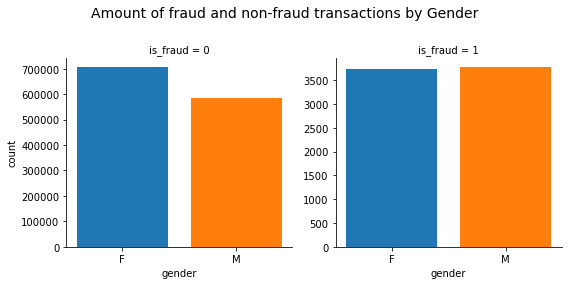

In [33]:
#Plot Count of Fraudulant and non-Fraudulant Transactions by Gender
plt.figure(figsize=(15, 6))
g = sns.FacetGrid(df_plot_gender, col = 'is_fraud', hue = 'gender',sharey=False,height=4, aspect=1)
g.map(plt.bar, 'gender', 'count')
g.fig.subplots_adjust(top=.8)
g.fig.suptitle('Amount of fraud and non-fraud transactions by Gender', fontsize=14)

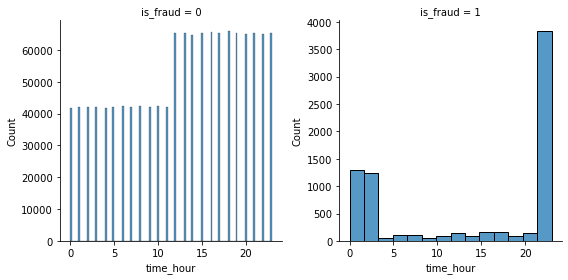

In [34]:
g = sns.FacetGrid(df, col="is_fraud",sharey=False,height=4, aspect=1)
g.map_dataframe(sns.histplot, x="time_hour")

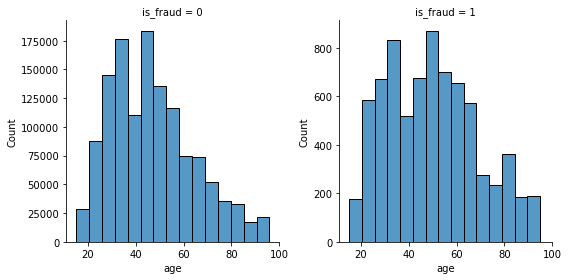

In [35]:
g = sns.FacetGrid(df, col="is_fraud",sharey=False,height=4, aspect=1)
g.map_dataframe(sns.histplot, x="age",bins=15)

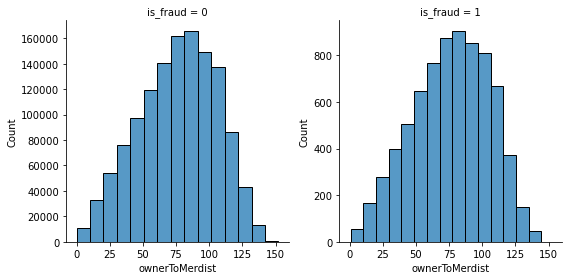

In [36]:
g = sns.FacetGrid(df, col="is_fraud",sharey=False,height=4, aspect=1)
g.map_dataframe(sns.histplot, x="ownerToMerdist",bins=15)

In [37]:
#Dataframe to plot distributions for time, age, distance between card owner and merchant, and amount of transaction
df_dist = pd.melt(df, id_vars = ['is_fraud'], 
                    value_vars = ['time_hour','age','ownerToMerdist','amt'])
df_dist

,is_fraud,variable,value
0,0,time_hour,0.00
1,0,time_hour,0.00
2,0,time_hour,0.00
3,0,time_hour,0.00
4,0,time_hour,0.00
...,...,...,...
5186695,0,amt,15.56
5186696,0,amt,51.70
5186697,0,amt,105.93
5186698,0,amt,74.90


In [38]:
%matplotlib inline

C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\axisgrid.py:670: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


Text(0.5, 1.6, 'Violin Plot Fraud vs Non-Fraud Transactions')

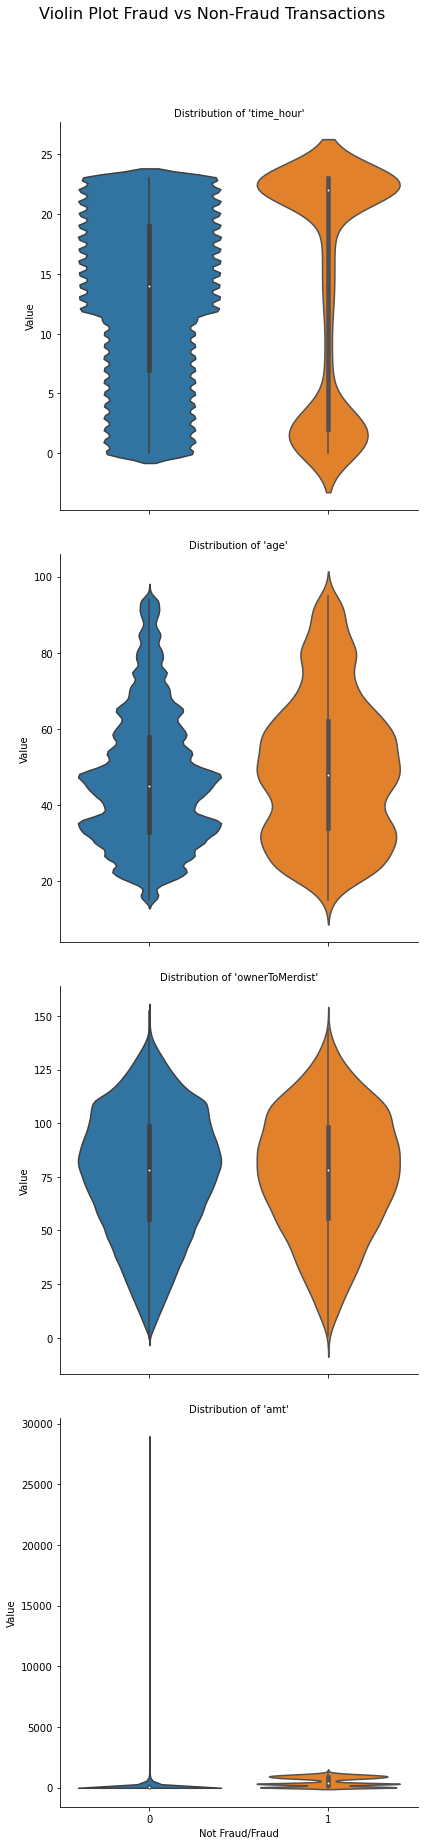

In [39]:
#Facet Grid with Violin plots showing distribution
g = sns.FacetGrid(df_dist, row = 'variable', hue='is_fraud',
                 height=4, aspect=1.5,sharey=False)
g.map(sns.violinplot,"is_fraud",'value')
g.set_titles("Distribution of '{row_name}'")
g.set_axis_labels('Not Fraud/Fraud', 'Value') 
g.fig.subplots_adjust(top=1.5)
g.fig.suptitle('Violin Plot Fraud vs Non-Fraud Transactions',y=1.6,fontsize=16)

In [40]:
df_amt = pd.melt(df, id_vars = ['is_fraud'], 
                    value_vars = ['amt'])
df_amt

,is_fraud,variable,value
0,0,amt,4.97
1,0,amt,107.23
2,0,amt,220.11
3,0,amt,45.00
4,0,amt,41.96
...,...,...,...
1296670,0,amt,15.56
1296671,0,amt,51.70
1296672,0,amt,105.93
1296673,0,amt,74.90


In [41]:
df_amt=df_amt.query("value<5000")

<AxesSubplot:xlabel='is_fraud', ylabel='value'>

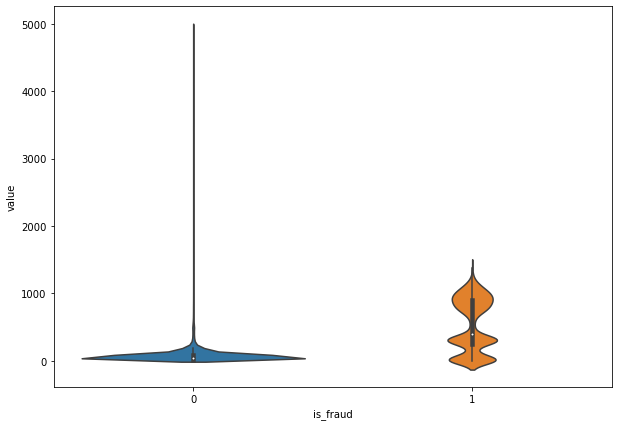

In [42]:
#Violine plot showing distribution of amount
plt.figure(figsize=(10,7))

sns.violinplot(data=df_amt,x='is_fraud',y='value')

In [43]:
# mean, median, 25 percentile, 75 percentile of amount for fraud and non-fraud
def q25(x): return x.quantile(0.25)
def q75(x): return x.quantile(0.75)
df.groupby('is_fraud').agg({'amt':['mean', 'median', q25, q75]}).round(0)


amt                     
           mean median    q25    q75
is_fraud                            
0          68.0   47.0   10.0   83.0
1         531.0  397.0  246.0  901.0

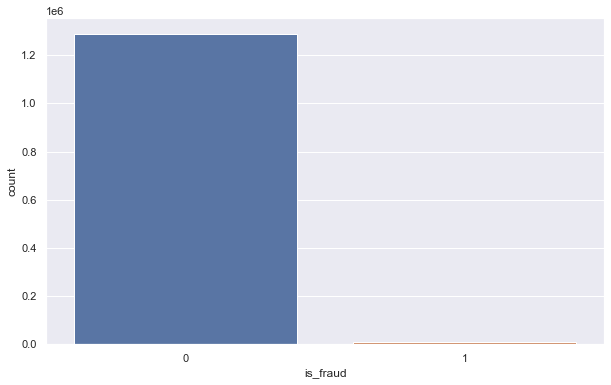

In [44]:
# check if the classes are imbalanced
#Ploting barplot for target 
plt.figure(figsize=(10,6))
sns.set_theme(style="darkgrid")
g = sns.countplot(x="is_fraud", data=df)


In [45]:
df['is_fraud'].value_counts()

0    1289169
1       7506
Name: is_fraud, dtype: int64

In [46]:
#class weights if we use balanced weighting
w0=len(df['is_fraud'])/(2*1289169)
w1=len(df['is_fraud'])/(2*7506)

print(f"weight for no fraud: {w0} , weight for fraud: {w1}")

weight for no fraud: 0.5029111776656126 , weight for fraud: 86.37589928057554


In [47]:
#set up test data frame (i.e data cleaning and feature engineering)
# delete unnamed column
df_test = file_test.loc[:, ~file_test.columns.str.contains('^Unnamed')]
#convert latitude and longitude radians for measuring distance
df_test['radian_lat'] = df_test.apply(lambda row: radians(row.lat), axis = 1)
df_test['radian_long'] = df_test.apply(lambda row: radians(row.long), axis = 1)
df_test['radian_mlat'] = df_test.apply(lambda row: radians(row.merch_lat), axis = 1)
df_test['radian_mlong'] = df_test.apply(lambda row: radians(row.merch_long), axis = 1)
# Add new column with distance between owner and merchant
df_test['ownerToMerdist']= dist(df_test['radian_lat'],df_test['radian_long'],df_test['radian_mlat'],df_test['radian_mlong'])
#add date_time column by converting trans_date_trans_time to date time 
df_test['date_time']=pd.to_datetime(df_test['trans_date_trans_time'])
# strip out date and time and add as new column
df_test['date']=df_test['date_time'].dt.date
df_test['time']=df_test['date_time'].dt.time
# strip out hour and add as new column
df_test['time_hour']=df_test['date_time'].dt.hour
# convert date of birth to date_time format
df_test['dob'] =pd.to_datetime(df_test['dob'], format='%Y/%m/%d')
# calculate age as of last date of dataset i.e "today"
df_test['dob'] = df_test['dob'].where(df_test['dob'] < now, df_test['dob'] -  np.timedelta64(100, 'Y'))   
df_test['age'] = (now - df_test['dob']).astype('<m8[Y]')   

In [48]:
df_test.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,radian_lat,radian_long,radian_mlat,radian_mlong,ownerToMerdist,date_time,date,time,time_hour,age
0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,...,0.592817,-1.412591,0.593174,-1.417220,24.569172,2020-06-21 12:14:25,2020-06-21,12:14:25,12,52.0
1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,...,0.703729,-1.927472,0.688541,-1.919172,104.958031,2020-06-21 12:14:33,2020-06-21,12:14:33,12,30.0
2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,...,0.709876,-1.283454,0.706785,-1.294966,59.098624,2020-06-21 12:14:53,2020-06-21,12:14:53,12,50.0
3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,Titusville,...,0.498635,-1.410559,0.502871,-1.411676,27.707262,2020-06-21 12:15:15,2020-06-21,12:15:15,12,33.0
4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,Falmouth,...,0.772359,-1.483827,0.784685,-1.498971,104.367859,2020-06-21 12:15:17,2020-06-21,12:15:17,12,65.0


In [49]:
#get columns to train model
df['gender'] = df['gender'].astype('category')
x_train=df[['time_hour','age','ownerToMerdist','amt']]
y_train=df[['is_fraud']]

In [50]:
#get columns to test model
df_test['gender'] = df_test['gender'].astype('category')
x_test=df_test[['time_hour','age','ownerToMerdist','amt']]
y_test=df_test[['is_fraud']]

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


The f1 score for the testing data: 0.10767006288039274


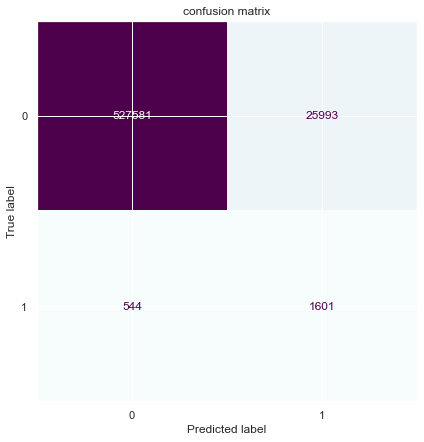

In [51]:
# run logistic regression with balanced class weights

#importing and training the model
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(class_weight='balanced')
lr.fit(x_train, y_train)

# Predicting on the test data
pred_test = lr.predict(x_test)

#Calculating and printing the f1 score 
f1_test = f1_score(y_test, pred_test)
print('The f1 score for the testing data:', f1_test)

#Ploting the confusion matrix
cm=confusion_matrix(y_test, pred_test)
fig, ax = plt.subplots(figsize=(7, 7))
disp =ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="BuPu",colorbar=False,ax=ax)
plt.title("confusion matrix")
plt.show()

In [52]:
print(f" Accuracy score: {accuracy_score(y_test, pred_test)}")
print(f" precision_score: {precision_score(y_test, pred_test)}")
print(f" recall_score: {recall_score(y_test, pred_test)}")
print(f" ROC score: {roc_auc_score(y_test, lr.predict_proba(x_test)[::,1])}")


 Accuracy score: 0.9522474488005629
 precision_score: 0.0580198593897224
 recall_score: 0.7463869463869464
 ROC score: 0.8301089888252581


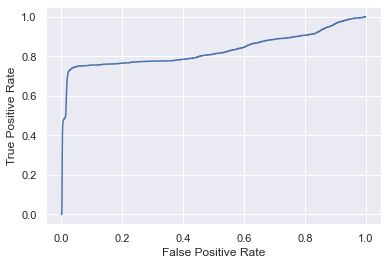

In [53]:
#define metrics
y_pred_proba = lr.predict_proba(x_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Scoring for different class weights')

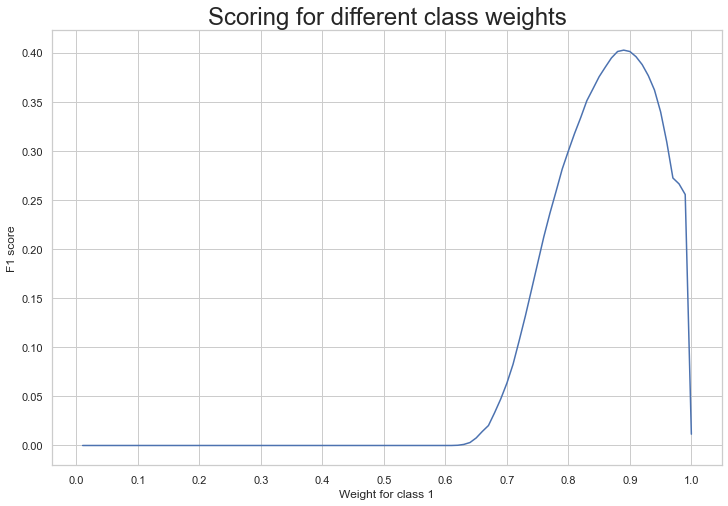

In [73]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
lr = LogisticRegression(solver='newton-cg')

#Setting the range for class weights
weights = np.linspace(0.0,0.99,100)

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

#Fitting grid search to the train data with 5 folds
gridsearch = GridSearchCV(estimator= lr, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(x_train, y_train)

#Ploting the score for different values of weight
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
weigh_data = pd.DataFrame({ 'score': gridsearch.cv_results_['mean_test_score'], 'weight': (1- weights)})
sns.lineplot(weigh_data['weight'], weigh_data['score'])
plt.xlabel('Weight for class 1')
plt.ylabel('F1 score')
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('Scoring for different class weights', fontsize=24)

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


The f1 score for the testing data: 0.34410163339382943


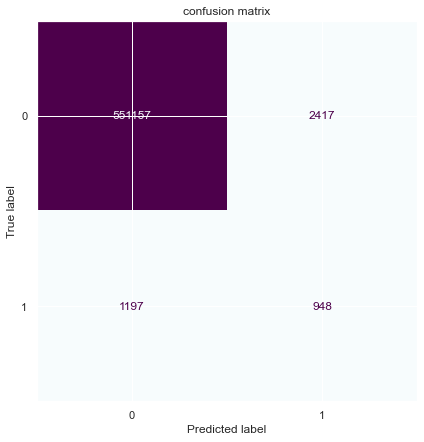

In [71]:
# run logistic regression with updated class weights

#importing and training the model
from sklearn.linear_model import LogisticRegression
lr2 = LogisticRegression(class_weight={0: 0.11, 1: 0.89})
lr2.fit(x_train, y_train)

# Predicting on the test data
pred_test2 = lr2.predict(x_test)

#Calculating and printing the f1 score 
f1_test2 = f1_score(y_test, pred_test2)
print('The f1 score for the testing data:', f1_test2)

#Ploting the confusion matrix
cm2=confusion_matrix(y_test, pred_test2)
fig, ax = plt.subplots(figsize=(7, 7))
disp =ConfusionMatrixDisplay(confusion_matrix=cm2)
disp.plot(cmap="BuPu",colorbar=False,ax=ax)
plt.title("confusion matrix")
plt.show()

In [72]:
print(f" Accuracy score: {accuracy_score(y_test, pred_test2)}")
print(f" precision_score: {precision_score(y_test, pred_test2)}")
print(f" recall_score: {recall_score(y_test, pred_test2)}")
print(f" ROC score: {roc_auc_score(y_test, lr2.predict_proba(x_test)[::,1])}")


 Accuracy score: 0.9934967132669569
 precision_score: 0.28172362555720654
 recall_score: 0.44195804195804195
 ROC score: 0.8343628611173691


In [84]:
#Reduce threshold
threshold = .1
y_pred3=((lr2.predict_proba(x_test)[::,1])>threshold).astype(np.int8) 

print(f" Accuracy score: {accuracy_score(y_test, y_pred3)}")
print(f" precision_score: {precision_score(y_test, y_pred3)}")
print(f" recall_score: {recall_score(y_test, y_pred3)}")


 Accuracy score: 0.9812171259215539
 precision_score: 0.12307972002545223
 recall_score: 0.6312354312354312


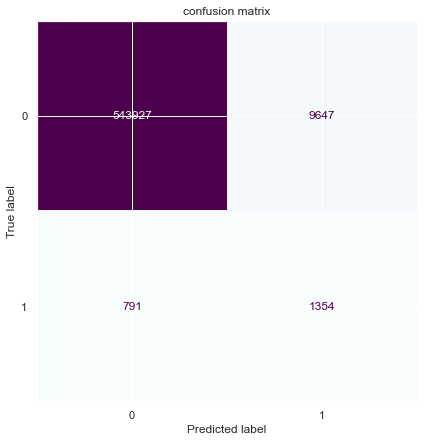

In [82]:
#Ploting the confusion matrix
cm3=confusion_matrix(y_test, y_pred3)
fig, ax = plt.subplots(figsize=(7, 7))
disp =ConfusionMatrixDisplay(confusion_matrix=cm3)
disp.plot(cmap="BuPu",colorbar=False,ax=ax)
plt.title("confusion matrix")
plt.show()

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


The f1 score for the testing data: 0.18842711781292143


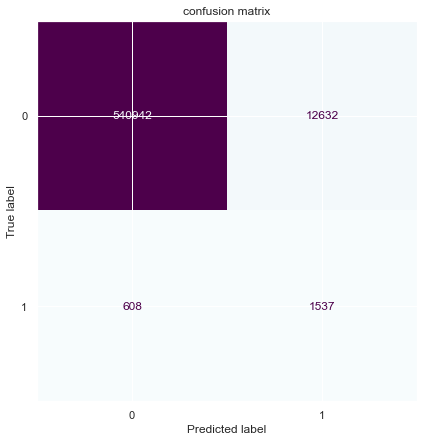

In [85]:
# run logistic regression with updated class weights

#importing and training the model
from sklearn.linear_model import LogisticRegression
lr2 = LogisticRegression(class_weight={0: 0.01, 1: 0.99})
lr2.fit(x_train, y_train)

# Predicting on the test data
pred_test2 = lr2.predict(x_test)

#Calculating and printing the f1 score 
f1_test2 = f1_score(y_test, pred_test2)
print('The f1 score for the testing data:', f1_test2)

#Ploting the confusion matrix
cm2=confusion_matrix(y_test, pred_test2)
fig, ax = plt.subplots(figsize=(7, 7))
disp =ConfusionMatrixDisplay(confusion_matrix=cm2)
disp.plot(cmap="BuPu",colorbar=False,ax=ax)
plt.title("confusion matrix")
plt.show()

In [86]:
print(f" Accuracy score: {accuracy_score(y_test, pred_test2)}")
print(f" precision_score: {precision_score(y_test, pred_test2)}")
print(f" recall_score: {recall_score(y_test, pred_test2)}")
print(f" ROC score: {roc_auc_score(y_test, lr2.predict_proba(x_test)[::,1])}")


 Accuracy score: 0.9761750093122603
 precision_score: 0.1084762509704284
 recall_score: 0.7165501165501166
 ROC score: 0.8312209704258464
